In [1]:
import classes
import functies
import sympy as sp
import numpy as np
from matplotlib import pyplot as plt
from os import listdir
from os.path import isfile, join

In [2]:
#puntje 2: definiëren van de functies
k, omega, p_0, p_0_x, phi, v, x, t = sp.symbols('k omega p_0 p_0_x phi v x t')

#max amplitude in functie van x 
drukamplitude_vergelijking = classes.vergelijking(p_0 * sp.sin(k*x + phi))
drukamplitude_parameters = ['k', 'p_0', 'phi', 'C']

def drukamplitude_model(X, parameters):
    K, P_0, PHI, C = parameters
    return P_0 * abs(np.sin(K*X + PHI) + C) #bij de x-fit steeds positief (anders breekt het omdat de vorige fit brakt)

#amplitude in functie van tijd voor vaste x 
druktijd_vergelijking = classes.vergelijking(p_0*sp.sin(omega*t+phi)) #merk op dat dit niet per sé dezelfde phi is als voor x, maar is irrelevant voor de fitcode
druktijd_parameters = ['omega', 'p_0_x', 'phi', 'C']

def druktijd_model(T, parameters):
    omega, P_0, phi, C = parameters
    return P_0*np.sin(omega*T+phi) + C

#snelheid als omega en k gekend zijn
snelheid_vergelijking = classes.vergelijking(omega/k *10**5) #de 10**5 is om de vage eenheden die nodig zijn om de fits te doen werken te fixen

In [3]:
###sjoemeliere sjoemelare om de txt files met de data om te zetten in effectieve nuttige dataverwerkingen
#blah blah...

###TEST_DATA:

X = np.array([0,100,200,300]) #een vector met de x-coordinaten van de metingen
T = np.array(
    [ np.linspace(1,15),
      np.linspace(0,10), #een matrix met de tijden voor elke meting op elke x-coordinaat
      np.linspace(1,11),
      np.linspace(7, 27)
])

P = np.array(
    [ 0*np.linspace(1,15) + np.random.normal(0,1),
     0.5*np.sin(np.linspace(0,10)+3)+np.random.normal(0,1), #een matrix met coordinaten P[x_coordinaat][tijd] #random normale fouten ingevoegd voor de test
          np.sin(np.linspace(0,10)+np.random.normal(0,1)), 
      0.5*np.sin(np.linspace(0,10)-1)+np.random.normal(0,1)
])
P_fout = np.full(np.shape(P), 1) #een matrix van dezelfde vorm als P met de fouten in



xval = 0

In [10]:
###vind de drukamplitude voor een vaste x-coordinaat
def fit_vaste_x(X, T, P, P_fout, invals = None, print_tijdfit = True, detailed_logs = False):
    """
    @IN:
    matrices X, T P en P_fout als gedefinieerd in vorige opgave
    @OUT:
    een lijst met maximale amplitude, in de volgorde van de x-coordinaat waarin ze voorkomen, en de pulsatie in datapuntvorm
    """
    
    P_0_x = []
    omega_x = []
    for xval in range(len(X)):
        def invals_amplitude(x,y):
            if invals is None:
                return [1,0,0,0]
            else:
                return invals[xval]
        druk = P[xval]
        drukfout = P_fout[xval]
        tijd = T[xval]
        tijdfit = functies.fit(druktijd_parameters, druktijd_model, invals_amplitude, tijd, druk, drukfout, detailed_logs = detailed_logs)
        print('\n\n')
        print(tijdfit, 'tijdfit')
        omega_x.append(functies.vector_to_datapunt(tijdfit[0].copy(), omega))
        P_0_x.append(tijdfit[1].copy())

        if print_tijdfit:
            #plot het boeltje om te testen
            fig, ax = plt.subplots(1,1, figsize = (30,10))
            ax.errorbar(tijd, druk, yerr = drukfout, label = 'gemeten', fmt = "o" ,zorder = 1)
            T_fit = np.linspace(0, max(tijd),30000)
            druk_fit = tijdfit[1][0]*np.sin(tijdfit[0][0]*T_fit+tijdfit[2][0]) + tijdfit[3][0]
            ax.plot(T_fit, druk_fit, label = 'model', zorder = 2)

            testing = np.full(np.shape(T_fit), np.max(druk)) #Mijn vader beweerde iets raar te zien in de data, dus ff checken
            testing_min = np.full(np.shape(T_fit), np.min(druk)) #tis fine denk ik
            ax.plot(T_fit, testing)
            ax.plot(T_fit, testing_min)

            ax.set_ylabel('$V_0$ [mV]')
            ax.set_xlabel('T (s)')
            ax.legend("druk in functie van tijd")
            ax.legend()
            plt.tight_layout()
            plt.show()


    OMEGA = functies.mu_sigma(omega_x, omega)

    
    return P_0_x, OMEGA

#fix de drukamplitude naar de x-coordinaat
def fit_naar_x(X, P_0_x, P_0_x_ERR, invals = None, detailed_logs = False, fuck_mijn_pc = True, fuck_CPU = False):
    def invals_naarx(x,y):
        if invals is None:
            return [0,0,0,0]
        else:
            return invals
    fitwaardes = functies.fit(drukamplitude_parameters, drukamplitude_model, invals_naarx, X, P_0_x, P_0_x_ERR, detailed_logs= detailed_logs, fuck_mijn_pc=fuck_mijn_pc, fuck_CPU = fuck_CPU)
    K = functies.vector_to_datapunt(fitwaardes[0], k)
    P_0 = functies.vector_to_datapunt(fitwaardes[1], p_0)
    PHI = functies.vector_to_datapunt(fitwaardes[2], phi)
    c = fitwaardes[3]
    return K, P_0, PHI, c

#voor de experimenten met vaste frequentie:
def fix_data(X, T, P, P_fout, invals_vaste_x = None, detailed_logs = False, print_tijdfit = True, fit_x_vals = True, fuck_CPU = False):
    #fit voor elke mogelijke vaste x zodat je amplitude(x) vindt
    P_0_x_lijst, OMEGA = fit_vaste_x(X, T, P, P_fout, invals_vaste_x, print_tijdfit = print_tijdfit, detailed_logs = detailed_logs)
    P_0_x = [P_0_x_elem[0] for P_0_x_elem in P_0_x_lijst]
    P_0_x_ERR = [P_0_x_elem[1] for P_0_x_elem in P_0_x_lijst]
    print(P_0_x_ERR, 'P_0(x): de error')
    P_0_x = np.array(P_0_x)
    #fix dat er geen random tuples meer in uw error staan:
    for indx in range(len(P_0_x_ERR)):
        if type(P_0_x_ERR[indx]) == tuple:
            P_0_x_ERR[indx] = (P_0_x_ERR[indx][0] + P_0_x_ERR[indx][1])/2
    P_0_x_ERR = np.array(P_0_x_ERR)

    P_0_x = abs(P_0_x)

    #fit nu amplitude(x)
    """
    #eerst als eens de punten plotten zodat we weten wat ermee aan te vangen indien het crasht
    fig, ax = plt.subplots(1,1, figsize = (30,10))
    ax.errorbar(X, P_0_x, yerr = P_0_x_ERR, label = 'gemeten', linestyle = ' ', marker = 'o')
    ax.set_ylabel('$V_0$ [mV]')
    ax.set_xlabel('x (m)')
    ax.legend("drukamplitude in functie van positie")
    ax.legend()
    plt.tight_layout()
    plt.show()
    """
    #en nu voor echt fitten
    #beginwaardes bepalen
    minimum = min(P_0_x)
    maximum = max(P_0_x)
    if not invals_vaste_x is None:
        omega_gok = invals_vaste_x[0][0]
    else:
        omega_gok = OMEGA.get_val()
    Kgok = omega_gok*10**5/380
    phigok = np.arcsin(P_0_x[0]/(maximum - minimum)) - Kgok*X[0]
    invals = [Kgok+5, maximum-minimum+20, phigok, minimum]
    if fit_x_vals:
        print('initial values', invals)
        K, P_0, PHI, c= fit_naar_x(X, P_0_x, abs(P_0_x_ERR),invals, detailed_logs = detailed_logs, fuck_CPU=fuck_CPU)

        x_fit = np.linspace(0,max(X))
        druk_fit = P_0.get_val()*abs(np.sin(K.get_val()*x_fit+PHI.get_val())) + c[0]
        #plot het boeltje
        fig, ax = plt.subplots(1,1, figsize = (30,10))
        ax.errorbar(X, P_0_x, yerr = P_0_x_ERR, label = 'gemeten', linestyle = ' ', marker = 'o')

        ax.plot(x_fit, druk_fit, label = 'model')

        ax.set_ylabel('$V_0$ [mV]')
        ax.set_xlabel('x (m)')
        ax.legend("drukamplitude in functie van positie")
        ax.legend()
        plt.tight_layout()
        plt.show()

        #bereken de snelheid
        snelheid = functies.data_analyse(snelheid_vergelijking, [OMEGA, K], v)
        print(snelheid)
        return [K, P_0, PHI, c, OMEGA]
    else:
        return [P_0_x, P_0_x_ERR, invals]


In [5]:
#### Hier volgt de effectieve data-analyse
#fix_data(X, T, P, P_fout, detailed_logs=False)

In [6]:
def X_tractor(inhoud): #extraheert effectief nuttige data uit die txt-files

    #@return: T in 10^-5 s (bro da werkt beter smh)

    #bepaal de initiële values van de fit (met de headerdata)
    amplitude = float(inhoud.split("PK-PK                :		")[1][:4])/2 #de helft van de peak-to-peak +20 om te kleine fits te breken
    freq = float(inhoud.split("Frequency            :		")[1][:4]) * 10**3 #het staat in kHz
    gesplit = inhoud.split('Time interval        :		')

    #bepaal de stapbreedte
    getal = ""
    eenheid = ""
    count = 0
    punt_gevonden = False
    for digit in gesplit[1]:
        if digit.isdigit():
            getal += digit
        elif digit == '.' and not punt_gevonden:
            getal += digit
            punt_gevonden = True
        else:
            eenheid+=digit
            count+=1
        if count == 2:
            break
    getal = float(getal)
    #fix de SI prefix van de stapbreedte
    if eenheid == "us": #bro een u voor µ deze oscilloscoop is ass
        stapbreedte = getal *10**(-1)# *10**(-6)
    elif eenheid == "ms":
        stapbreedte = getal * 10**2
    else:
        raise ChildProcessError("children have defined units of " + eenheid)
    #haal de twee kolommen uit de txt-file en transponeer ze
    tabel = gesplit[1].split('index		CH1_Voltage(mV)\n')[1]
    nuttigtransponent = [X.split('		') for X in tabel.split('\n')][:-1] #skip het laatste element want dat is leeg (een enter op het einde van de txt)
    nuttig = [[float(nuttigtransponent[j][i]) for j in range(len(nuttigtransponent))] for i in range(len(nuttigtransponent[0]))]
    #fix de verder gebruikte arrays in analyse
    T = np.array(nuttig[0])*stapbreedte
    T = T - T[0] #gezien het toch periodisch is kunnen we het laten starten bij nul
    Vpart = np.array(nuttig[1])        
    
    C = (np.max(Vpart)+np.min(Vpart))/2 #zou ook moeten werken i guess
    

    if Vpart[0] < Vpart[1]:
        phi = np.arcsin((Vpart[0] - C)/amplitude)
    else:
        phi = np.pi - np.arcsin((Vpart[0] - C)/amplitude)

    

    
    invals = [2*np.pi*freq*10**(-5), amplitude, phi, C] #Was eerder 4*pi*freq, maar omega=2pif, dus idk wat het plan was
    #Eenheden zijn enorm cooked, 10^-5 factor moet nog bij freq om shit te doen kloppen, zie twee code blokken verder, hier wat getest (werkte op oude code)
    return T, Vpart, eenheid, invals

In [7]:
def uncook_data(Tpart, Vpart, V_part_fout):
    Tnew = []
    Vnew = []
    Verrnew = []
    indx = 0
    while indx < len(Tpart)-1:
        indx2 = indx
        while indx2 < len(Tpart)-1 and Tpart[indx] == Tpart[indx2]:
            indx2 += 1
        
        tijd = np.mean(np.array([Tpart[ind] for ind in range(indx, indx2)]))
        spanning = Vpart[indx]
        fout = np.sqrt(indx2 - indx)*V_part_fout[indx]
        Tnew.append(tijd)
        Vnew.append(spanning)
        Verrnew.append(fout)
        indx = indx2
    Tnew = np.array(Tnew)
    Vnew = np.array(Vnew)
    Verrnew = np.array(Verrnew)
    assert np.shape(Verrnew) == np.shape(Vnew)
    return Tnew, Vnew, Verrnew

def get_data_from_folder(mypath):
    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))] #met dank aan StackOverflow: een lijst met alle files in mypath
    afstanden = []
    T = []
    V = []
    invals = []
    Vfout = []
    #for i in range(5):
    COOKED = 0
    for filenaam in onlyfiles[1:]:# -------- Ik heb er ff voor gezorgd dat enkel de eerste 5 files gefit worden voor debugging purposes
        #                            ------- De eerste meting is een uitschieter dus skip die
        #filenaam = onlyfiles[i]
        nummer = float(filenaam[9:-4])*10**(-3)
        afstanden.append(nummer)
        bestand = open(mypath + '/' +filenaam,'rt')
        inhoud = bestand.read()
        bestand.close()
        Tpart, Vpart, eenheid, invals_vaste_x = X_tractor(inhoud)
        Vfout_part = np.full(np.shape(Vpart), 0.1)
        COOKEDbool = False
        for indx in range(len(Vpart)-2):
            if Vpart[indx] == Vpart[indx+1] == Vpart[indx+2]:
                print('FUCK YOU DE DATA IS COOKED')
                COOKEDbool = True

        if COOKEDbool:
            COOKED += 1
            Tpart, Vpart, Vfout_part = uncook_data(Tpart, Vpart, Vfout_part)
        V.append(Vpart[::2].copy()) #Dubbele sinusfunctie moet unzipped worden, dus om de index pakken als fix. Tis nogsteeds kapot, 
        #maar wss zullen amplitude en freq hetzelfde zijn, gwn andere +C
        T.append(Tpart[::2].copy())
        invals.append(invals_vaste_x.copy())
        Vfout.append(Vfout_part[::2].copy())
    print(COOKED)
    V = np.array(V)
    afstanden = np.array(afstanden)
    invals = np.array(invals)
    T = np.array(T)
    return [V, T, Vfout, afstanden, invals]

In [8]:
"""fig, ax = plt.subplots(1,1, figsize=(30,10))
ax.errorbar(afstanden, np.transpose(invals)[1], fmt='o')
plt.show()"""

"fig, ax = plt.subplots(1,1, figsize=(30,10))\nax.errorbar(afstanden, np.transpose(invals)[1], fmt='o')\nplt.show()"

FUCK YOU DE DATA IS COOKED
1
Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1314769.2944890196
             x: [ 6.663e-02  2.409e+01  3.149e+00  6.285e+00]
           nit: 222
          nfev: 369
 final_simplex: (array([[ 6.663e-02,  2.409e+01,  3.149e+00,  6.285e+00],
                       [ 6.663e-02,  2.409e+01,  3.149e+00,  6.285e+00],
                       ...,
                       [ 6.663e-02,  2.409e+01,  3.149e+00,  6.285e+00],
                       [ 6.663e-02,  2.409e+01,  3.149e+00,  6.285e+00]]), array([ 1.315e+06,  1.315e+06,  1.315e+06,  1.315e+06,
                        1.315e+06]))
functie(chimin) [-4.69542232]
functie(chimin) [-4.69542232]
functie(chimin) [-4.69542232]
functie(chimin) [-4.69542232]
[[0.06663281232749563, 0.10840535996484753], [24.083276456521737, 24.091952289503634], [3.1483387596397807, 3.1486982536116312], [6.282321576148621, 6.288450487477068]]
omega heeft als waarde: 0.

c:\Users\User\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


functie(chimin) [-4.69542232]
[[0.0004395082475692039, 0.1084731267545844], [82.8068064670484, 82.81550572428964], [2.5413334470513504, 2.5414377359417295], [5.921886126645486, 5.928015028161225]]
omega heeft als waarde: 0.066644 + 0.041829 - 0.066204 met 68% betrouwbaarheidsinterval: [0.00043951, 0.10847] 
p_0_x heeft als waarde: 82.811 + 0.0043339 - 0.0043654 met 68% betrouwbaarheidsinterval: [82.807, 82.816] 
phi heeft als waarde: 2.5414 + 5.2168e-05 - 5.2121e-05 met 68% betrouwbaarheidsinterval: [2.5413, 2.5414] 
C heeft als waarde: 5.9249 + 0.0030682 - 0.0030607 met 68% betrouwbaarheidsinterval: [5.9219, 5.928] 
De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: 0
De gereduceerde chi^2 waarde is: 555.44



[[0.06664363065956147, (0.066, 0.042), 'S'], [82.81117186962345, 0.0044, 'S'], [2.54138556792898, 5.2e-05, 'S'], [5.924946864254247, 0.0031, 'S']] tijdfit
Raw output
       message: Optimization terminated successfully.
       success: True
        s

c:\Users\User\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


functie(chimin) [-4.69542232]
functie(chimin) [-4.69542232]
[[0.06665682928276613, 0.0666567848325619], [168.08875596600242, 168.09745551808345], [2.4473859834536498, 2.4474373594506496], [-3.7869500354479677, -3.7930789371623255]]
omega heeft als waarde: 0.066657 + -2.2217e-08 - -2.2233e-08 met 68% betrouwbaarheidsinterval: [0.066657, 0.066657] 
p_0_x heeft als waarde: 168.09 + 0.0043551 - 0.0043445 met 68% betrouwbaarheidsinterval: [168.09, 168.1] 
phi heeft als waarde: 2.4474 + 2.5719e-05 - 2.5657e-05 met 68% betrouwbaarheidsinterval: [2.4474, 2.4474] 
C heeft als waarde: -3.79 + -0.0030607 - -0.0030682 met 68% betrouwbaarheidsinterval: [-3.787, -3.7931] 
De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: 0
De gereduceerde chi^2 waarde is: 4582.7



[[0.06665680704983262, -2.2e-08, 'S'], [168.09310044941233, 0.0044, 'S'], [2.4474116406686033, 2.6e-05, 'S'], [-3.7900182739732062, -0.0031, 'S']] tijdfit
Raw output
       message: Optimization terminated su

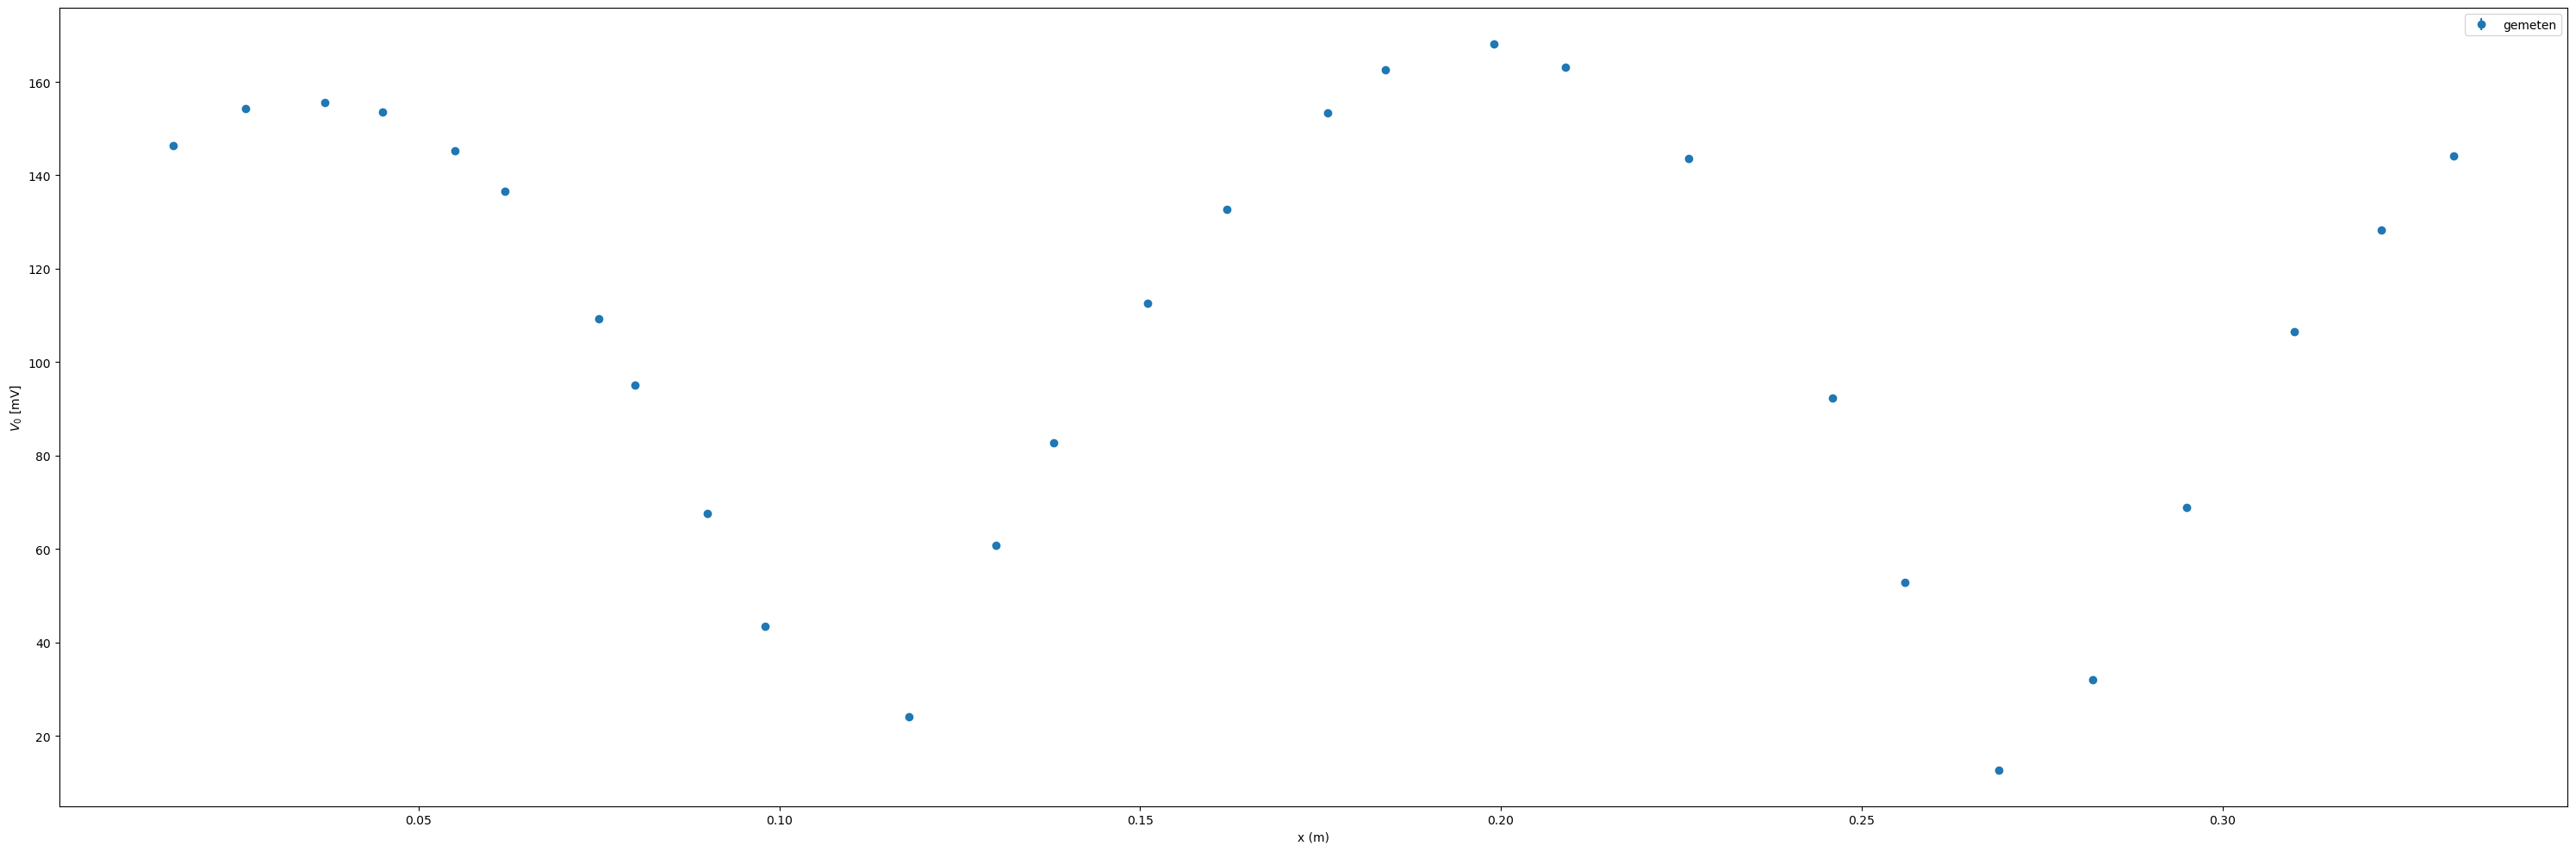

initial values [22.361433085627805, 175.38679338092112, -1.8930042596944723, 12.706307068491203]
Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 17859740.385690138
             x: [ 1.988e+01  1.628e+02 -2.262e+00  3.517e-02]
           nit: 303
          nfev: 527
 final_simplex: (array([[ 1.988e+01,  1.628e+02, -2.262e+00,  3.517e-02],
                       [ 1.988e+01,  1.628e+02, -2.262e+00,  3.517e-02],
                       ...,
                       [ 1.988e+01,  1.628e+02, -2.262e+00,  3.517e-02],
                       [ 1.988e+01,  1.628e+02, -2.262e+00,  3.517e-02]]), array([ 1.786e+07,  1.786e+07,  1.786e+07,  1.786e+07,
                        1.786e+07]))
functie(chimin) [-4.69542232]
functie(chimin) [-4.69542232]
functie(chimin) [-4.69542232]
functie(chimin) [-4.69542232]
[[19.877464521767866, 19.87762384539827], [162.7562828966424, 162.7612368899896], [-2.2622080325791747, -2.2621756522715746], [

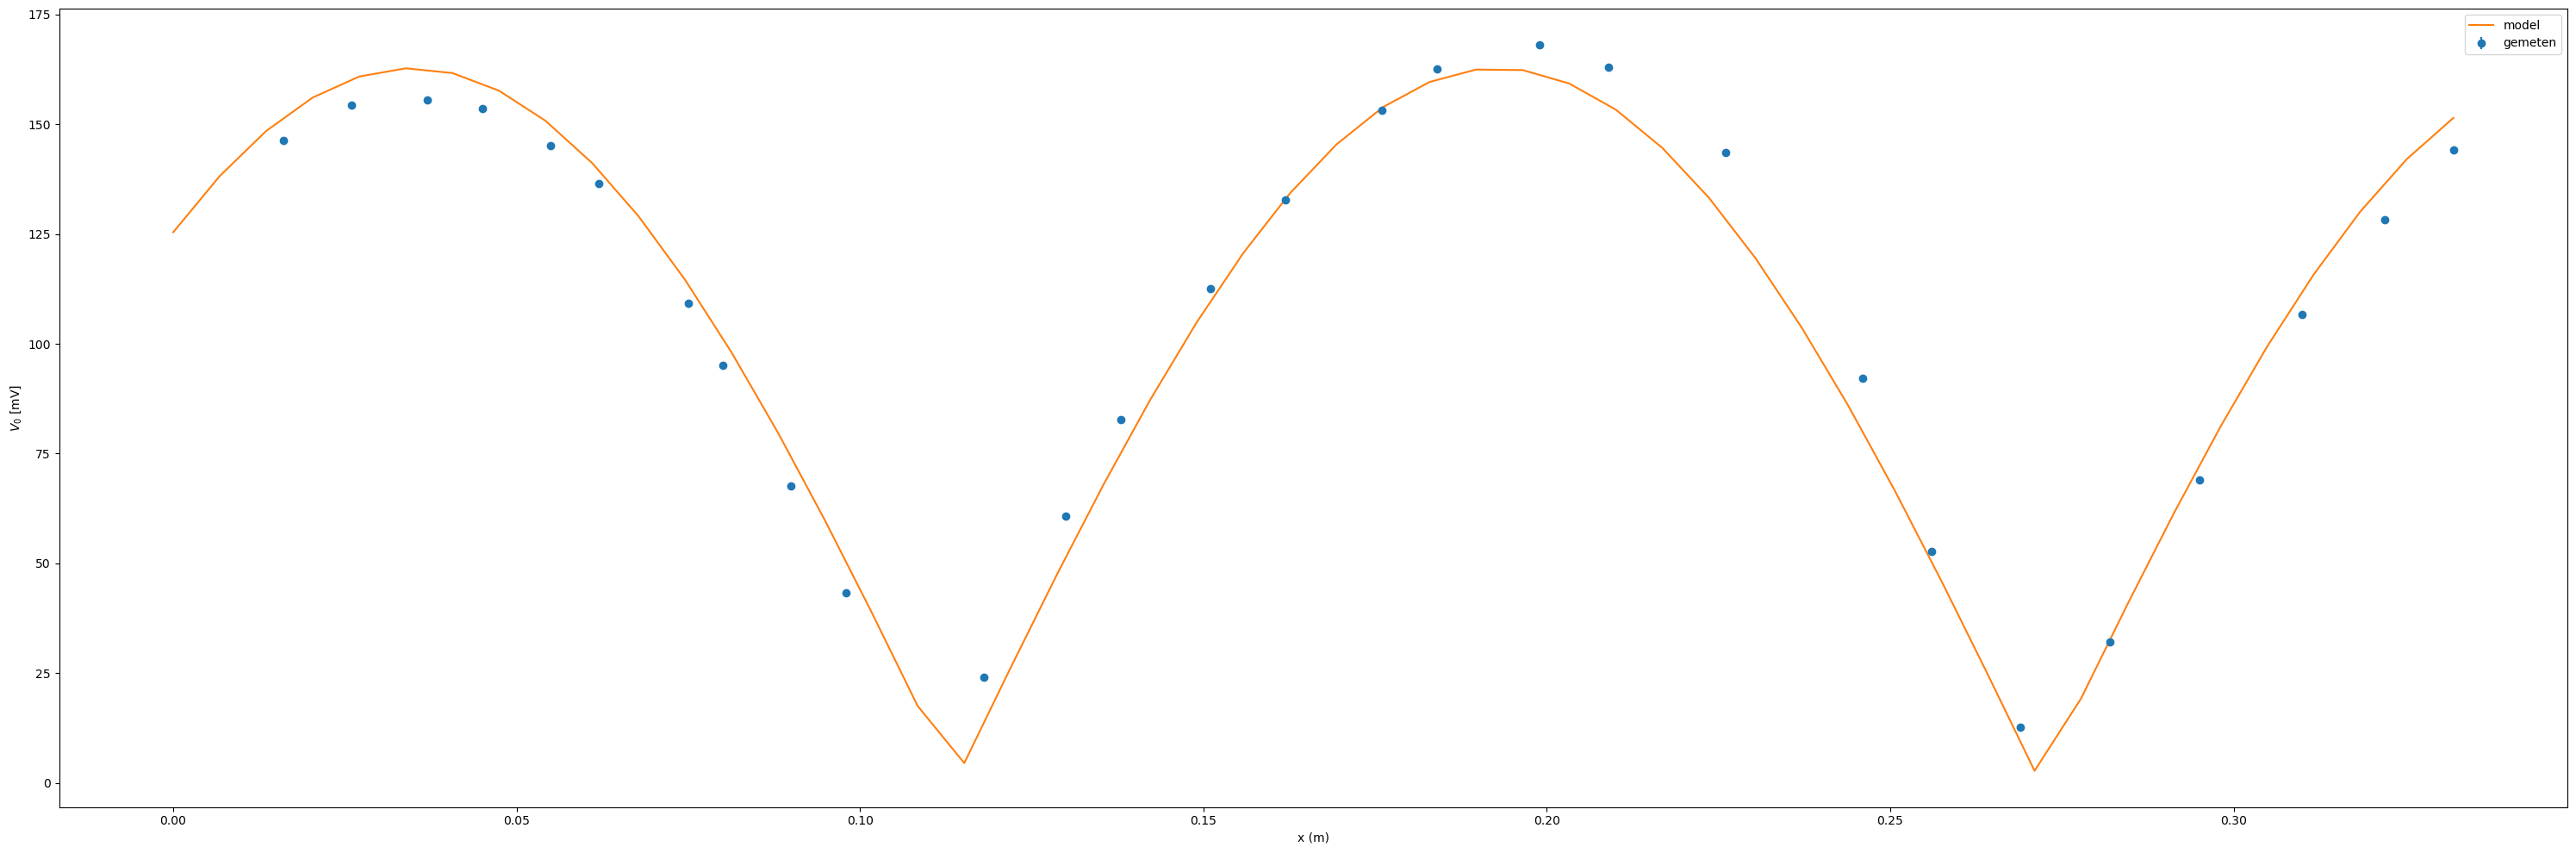

datapunt: v = [335.337232982384, 0.00135414288454668, 'Normaal']


FileNotFoundError: [WinError 3] Het systeem kan het opgegeven pad niet vinden: 'metingen laweit/1000Hz, 60.0cm'

In [ ]:
#de experimenten op 1000Hz
#experiment 1: 1000 Hz, 35,3cm
lengtes = ['35.3', '50.0', '26.1']
for lengte in lengtes:
    mypath = "metingen laweit/1000Hz, "+lengte+"cm"
    V, T, V_fout, afstanden, invals = get_data_from_folder(mypath)
    invals_tijd = invals.copy()
    invals_tijd = np.transpose(invals_tijd)
    invals_tijd[3] -= 10
    invals_tijd = np.transpose(invals_tijd)
    fix_data(afstanden, T, V, V_fout, invals_tijd, detailed_logs=False, print_tijdfit = False, fit_x_vals=True, fuck_CPU = True)
    #amp_x, amp_x_error, invals_x = fix_data(afstanden, T, V, V_fout, invals_tijd, detailed_logs=False, print_tijdfit = False, fit_x_vals=False)

In [ ]:
"""invals_x
fig,ax = plt.subplots(1,1, figsize=(30,10))
ax.errorbar(afstanden, amp_x, yerr=amp_x_error, fmt = "o")
afst = np.linspace(0,0.4, 10000)
ax.plot(afst, np.abs(invals_x[1]*np.sin(invals_x[0]*afst + invals_x[2]) + invals_x[3]))
plt.show()"""

In [ ]:
"""invals_x_alt = invals_x.copy()
K, P_0, PHI, c = fit_naar_x(afstanden, amp_x, amp_x_error, invals_x_alt, detailed_logs=True, fuck_mijn_pc = False, fuck_CPU = True)
fig, ax = plt.subplots(1,1, figsize = (30,10))
ax.errorbar(afstanden, amp_x, yerr=amp_x_error, fmt = "o")
druk_fit = P_0.get_val()*abs(np.sin(K.get_val()*afst+PHI.get_val())) + c[0]
ax.plot(afst, druk_fit)
plt.show()"""